# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import first as Ffirst
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1631304448721_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# packages that may need to be installed
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("Cython")
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("sklearn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…




  Running setup.py bdist_wheel for sklearn: started
  Running setup.py bdist_wheel for sklearn: finished with status 'done'
  Stored in directory: /var/lib/livy/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn

In [3]:
#python libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
#load data set
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# look at the schema of the data
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [7]:
# filter the dataframe such as to exclude users without ids
df_clean = df.filter(df.userId != '')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# convert timestamp column to actual dates
df_clean=df_clean.withColumn("date", from_unixtime(col("ts")/1000))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
# Monthly unique active users

monthly_active_users = df_clean.filter(col("page")=="NextSong") \
.select('userId',date_trunc('month','date').alias('date')) \
.dropDuplicates(subset=['userId','date']) \
.groupby(['date']) \
.count() \
.toPandas()

monthly_active_users['date'] = monthly_active_users['date'].dt.strftime('%Y/%m')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

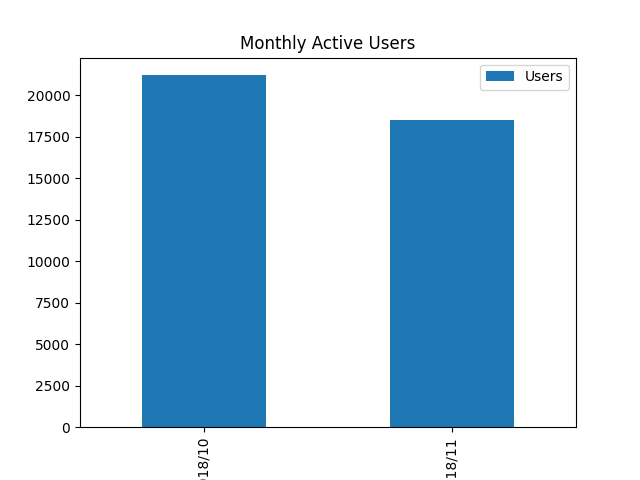

In [10]:
#manually removing december 2018 since it only has 1 user
monthly_active_users = monthly_active_users[monthly_active_users.date != '2018/12']
# Plot the monthly active users
monthly_active_users.sort_values(by='date',inplace=True)
monthly_active_users.plot.bar(x='date',y='count',title='Monthly Active Users')
plt.legend(['Users'])
%matplot plt

In [11]:
# Free users by month
monthly_free_users = df_clean.filter(col("level") == "free") \
.select('userId',date_trunc('month','date').alias('date')) \
.dropDuplicates(subset=['userId','date']) \
.groupby(['date']) \
.count() \
.toPandas()

monthly_free_users['date'] = monthly_free_users['date'].dt.strftime('%Y/%m')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

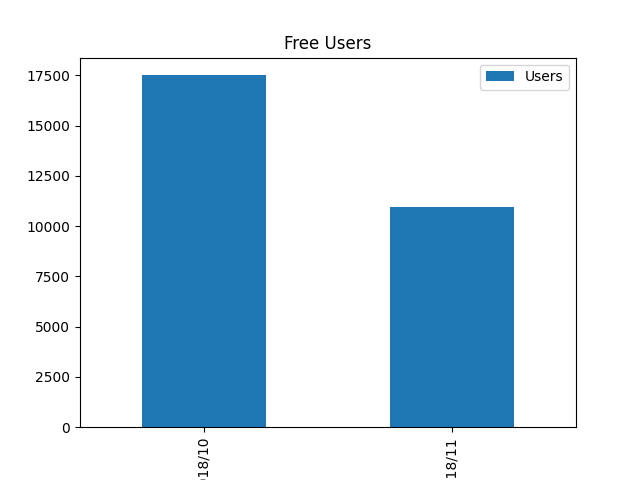

In [12]:
# removing december 2018 since it only has 2 users
monthly_free_users = monthly_free_users[monthly_free_users.date != '2018/12']
# Plot the free users by month
monthly_free_users.sort_values(by='date',inplace=True)
monthly_free_users.plot.bar(x='date',y='count',title='Free Users')
plt.legend(['Users']);
%matplot plt

In [13]:
# paid users by month
monthly_paid_users = df_clean.filter(col("level") == "paid") \
.select('userId',date_trunc('month','date').alias('date')) \
.dropDuplicates(subset=['userId','date']) \
.sort(['date']) \
.groupby(['date']) \
.count() \
.toPandas()

monthly_paid_users['date'] = monthly_paid_users['date'].dt.strftime('%Y/%m')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

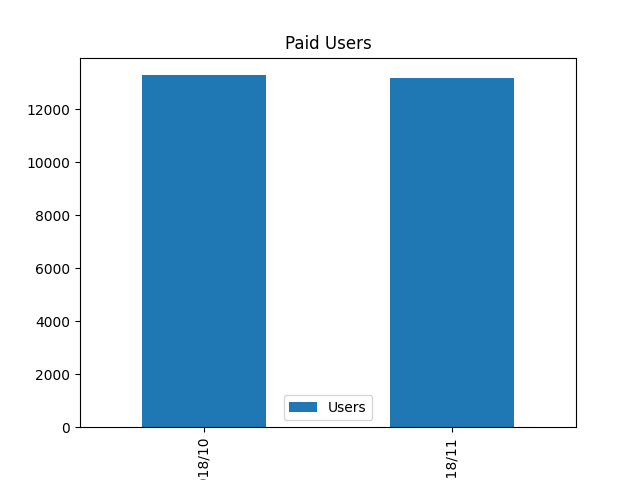

In [14]:
# Plot the paid users by month
monthly_paid_users.sort_values(by='date',inplace=True)
monthly_paid_users.plot.bar(x='date',y='count',title='Paid Users')
plt.legend(['Users']);
%matplot plt

In [15]:
#adds delivered by month
adds_per_month = df_clean.filter(col("page")=="Roll Advert") \
.select('userId',date_trunc('month','date').alias('date')) \
.sort(['date']) \
.groupby(['date']) \
.count() \
.toPandas()

adds_per_month['date'] = adds_per_month['date'].dt.strftime('%Y/%m')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

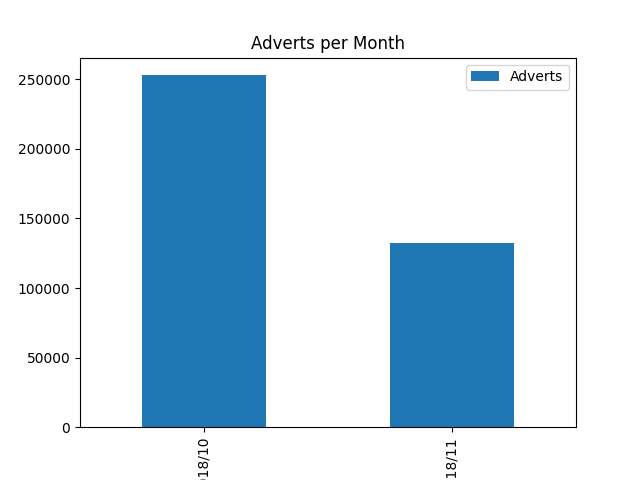

In [16]:
# Plot the adverts by month
adds_per_month.sort_values(by='date',inplace=True)
adds_per_month.plot.bar(x='date',y='count',title='Adverts per Month')
plt.legend(['Adverts']);
%matplot plt

In [17]:
#upgrades a month
upgrades_per_month = df_clean.filter(col("page")=="Submit Upgrade") \
.select('userId',date_trunc('month','date').alias('date')) \
.sort(['date']) \
.groupby(['date']) \
.count() \
.toPandas()

upgrades_per_month['date'] = upgrades_per_month['date'].dt.strftime('%Y/%m')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

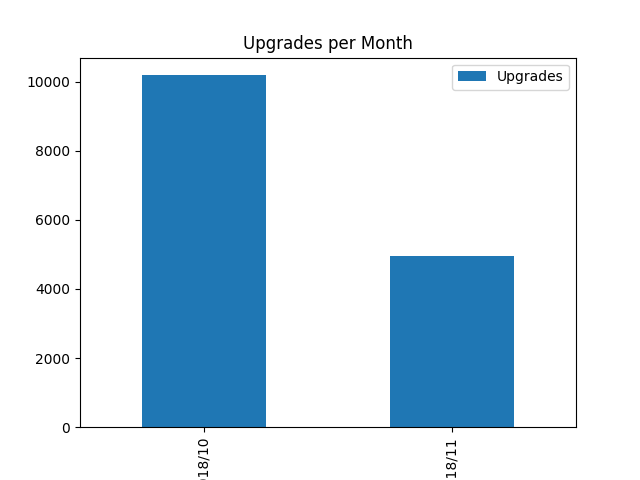

In [18]:
# Plot the upgrades by month
upgrades_per_month.sort_values(by='date',inplace=True)
upgrades_per_month.plot.bar(x='date',y='count',title='Upgrades per Month')
plt.legend(['Upgrades']);
%matplot plt

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [19]:
# users that churn within a given month
churn_per_month = df_clean.filter(col("page")=="Cancellation Confirmation") \
.select('userId',date_trunc('month','date').alias('date')) \
.dropDuplicates() \
.sort(['date']) \
.groupby(['date']) \
.count() \
.toPandas()

churn_per_month['date'] = churn_per_month['date'].dt.strftime('%Y/%m')
churn_per_month = churn_per_month.merge(monthly_paid_users,on='date',how='left')
churn_per_month['percentage']=churn_per_month.count_x/churn_per_month.count_y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

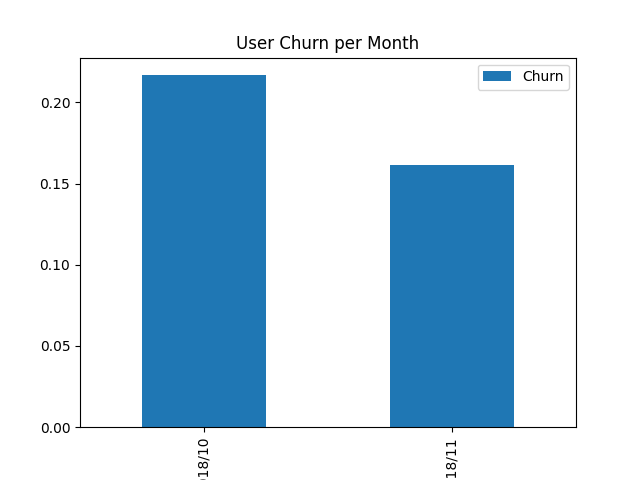

In [20]:
# Plot the users that churn by month
churn_per_month.sort_values(by='date',inplace=True)
churn_per_month.plot.bar(x='date',y='percentage',title='User Churn per Month')
plt.legend(['Churn']);
%matplot plt

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessaryfeatures from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [21]:
#select churn date for users that churned, max date for users that did not churn

#for users that churned
df_churn = df_clean.filter(df_clean.page=="Cancellation Confirmation").select('userId',date_trunc('day','date')).dropDuplicates()
newcolumns = ['userId','churn_date']
df_churn = df_churn.toDF(*newcolumns)

#for users that did not churn
df_no_churn = df_clean.select('userId').dropDuplicates().subtract(df_churn.select('userId'))
max_date_nochurn = df_clean.select('userId','date').groupBy('userId').agg(date_trunc('day',Fmax('date')).alias('churn_date'))
df_no_churn = df_no_churn.join(max_date_nochurn,on='userId',how='left')

#concat the two dataframes into one
df_churn=df_churn.union(df_no_churn)

#subtract 10 days from the churn dates
df_churn = df_churn.withColumn('10days_before_churn',date_sub('churn_date',10))

#use pandas to create dataframe that contains all the 10 days before churning
churn_dates_pd = df_churn.toPandas()
churn_dates_pd['10days_before_churn'] = pd.to_datetime(churn_dates_pd['10days_before_churn'])
user_date_df = pd.DataFrame()
for user in churn_dates_pd.userId:
    date_range = pd.date_range(start = churn_dates_pd['10days_before_churn'][churn_dates_pd.userId == user].values[0], end = churn_dates_pd['churn_date'][churn_dates_pd.userId == user].values[0], freq='1D', normalize=True)
    tempdf = pd.DataFrame()
    tempdf['date']=date_range
    tempdf['userId']=user
    user_date_df = pd.concat([user_date_df,tempdf])
    
feature_df = spark.createDataFrame(user_date_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
#start creating features

# filter the initial data frame to a timeframe between churn_date and 10days_before_churn
df_relevant_data = df_clean.join(df_churn,on='userId',how='left') \
.filter((col('date')<=col('churn_date')) & (col('date')>=col('10days_before_churn')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# calculate feature song_user_day_norm
song_per_user_day = df_relevant_data.filter(col('page')=="NextSong")\
.select('userId','date') \
.groupBy(['userId',date_trunc('day',"date")]) \
.count()\

newcolumns = ['userId', 'date', 'song_per_user_day']
song_per_user_day = song_per_user_day.toDF(*newcolumns)

avg_songs_user_day = song_per_user_day.groupby('userId') \
.avg('song_per_user_day') \

song_user_day_norm = song_per_user_day.join(avg_songs_user_day,on='userId')
newcolumns = ['userId', 'date', 'song_per_user_day', 'song_per_user_mean']
song_user_day_norm = song_user_day_norm.toDF(*newcolumns)
song_user_day_norm = song_user_day_norm.withColumn('song_user_day_norm', (song_user_day_norm.song_per_user_day-song_user_day_norm.song_per_user_mean)/song_user_day_norm.song_per_user_mean)
song_user_day_norm = song_user_day_norm.select('userId','date','song_user_day_norm')
feature_df= feature_df.join(song_user_day_norm,on=['userId','date'],how='left').fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
#calculate feature adverts / song 
advert_per_user_day = df_relevant_data.filter(col('page')=="Roll Advert")\
.select('userId','date') \
.groupBy(['userId',date_trunc('day',"date").alias('date')]) \
.count()\

newcolumns = ['userId', 'date', 'advert_per_user_day']
advert_per_user_day = advert_per_user_day.toDF(*newcolumns)

advert_per_user_day = advert_per_user_day.join(song_per_user_day,on=['userId','date'],how='left') \
.withColumn('advert/song', col("advert_per_user_day") / col("song_per_user_day")) \
.select('userId','date','advert/song')

feature_df = feature_df.join(advert_per_user_day,on=['userId','date'],how='left').fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
#calculate feature thumbs down / song
thumbs_down_per_user_day = df_relevant_data.filter(col('page')=="Thumbs Down")\
.select('userId','date') \
.groupBy(['userId',date_trunc('day',"date").alias('date')]) \
.count()\

newcolumns = ['userId', 'date', 'thumbs_down_per_user_day']
thumbs_down_per_user_day = thumbs_down_per_user_day.toDF(*newcolumns)

thumbs_down_per_user_day = thumbs_down_per_user_day.join(song_per_user_day,on=['userId','date'],how='left') \
.withColumn('thumbs_down/song', col("thumbs_down_per_user_day") / col("song_per_user_day")) \
.select('userId','date','thumbs_down/song')

feature_df = feature_df.join(thumbs_down_per_user_day, on=['userId','date'],how='left').fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
#calculate feature thumbs up / song
thumbs_up_per_user_day = df_relevant_data.filter(col('page')=="Thumbs Up")\
.select('userId','date') \
.groupBy(['userId',date_trunc('day',"date").alias('date')]) \
.count()\

newcolumns = ['userId', 'date', 'thumbs_up_per_user_day']
thumbs_up_per_user_day = thumbs_up_per_user_day.toDF(*newcolumns)

thumbs_up_per_user_day = thumbs_up_per_user_day.join(song_per_user_day,on=['userId','date'],how='left') \
.withColumn('thumbs_up/song', col("thumbs_up_per_user_day") / col("song_per_user_day")) \
.select('userId','date','thumbs_up/song')

feature_df = feature_df.join(thumbs_up_per_user_day, on=['userId','date'],how='left').fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
#calculate feature "downgrade page visited"
downgrade_page_per_user_day = df_relevant_data.filter(col('page')=="Downgrade")\
.select('userId','date') \
.groupBy(['userId',date_trunc('day',"date").alias('date')]) \
.count()\

newcolumns = ['userId', 'date', 'downgrade_page']
downgrade_page_per_user_day = downgrade_page_per_user_day.toDF(*newcolumns)

feature_df = feature_df.join(downgrade_page_per_user_day, on=['userId','date'],how='left').fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
#replace the dates with generic labels of how many days before churn it is
windowSpec = Window.partitionBy(feature_df.userId).orderBy('userId')
feature_df = feature_df.withColumn("row_number",row_number().over(windowSpec))
feature_df = feature_df.withColumn("date",concat(lit("prediction_minus_"),col("row_number")-1)).drop(feature_df.row_number)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
#pivot the feature_df to have the features for each of the 10 days before churning as a column
feature_df = feature_df.persist()
feature_pivot = feature_df \
.groupBy('userId') \
.pivot('date') \
.agg(Ffirst('song_user_day_norm').alias('song_user_day_norm_ind'),Ffirst('thumbs_up/song').alias('thumbs_up/song_ind'),Ffirst('thumbs_down/song').alias('thumbs_down/song_ind'),Ffirst('advert/song').alias('advert/song_ind'),Ffirst('downgrade_page').alias('downgrade_page_ind'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
#add an indicator whether a user has churned or not to the pivoted table
churn_users = df_clean.filter(col('page') == "Cancellation Confirmation").select('userId').distinct()
churn_users = churn_users.withColumn("indicator",lit("1"))

non_churn_users = df_clean.select('userId').distinct().subtract(churn_users.select('userId')).withColumn("indicator",lit("0"))

users_with_indicators = churn_users.union(non_churn_users)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
#merge this onto the pivoted table
feature_pivot = feature_pivot.join(users_with_indicators,on='userId',how='left').dropna()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [32]:
#use the vector assembler to get the code into the correct form to use the randomforestclassifier
assembler = VectorAssembler(
    inputCols=feature_pivot.columns[1:-1],
    outputCol='features')

trainingData = assembler.transform(feature_pivot)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
#make sure the indicator is numeric, not a string
trainingData = trainingData.withColumn("indicator",trainingData.indicator.cast("double"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
#perform a train-test split
train, test = trainingData.randomSplit([0.7, 0.3], seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
#instantiate and train the model
rf = RandomForestClassifier(featuresCol ='features' , labelCol = 'indicator')
rfModel = rf.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
#run predictions on the train and test set
predictions_train = rfModel.transform(train)
predictions_test = rfModel.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
#evaluation on the training set
precision_recall_fscore_support(predictions_train.select('indicator').rdd.flatMap(lambda x: x).collect(),predictions_train.select('prediction').rdd.flatMap(lambda x: x).collect(),average='weighted')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.8103787687480306, 0.7792760823278921, 0.6872767964511187, None)

In [38]:
#evaluation on the testing set
precision_recall_fscore_support(predictions_test.select('indicator').rdd.flatMap(lambda x: x).collect(),predictions_test.select('prediction').rdd.flatMap(lambda x: x).collect(),average='weighted')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7710818185262491, 0.7771057678123617, 0.6819140274185432, None)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.